In [1]:
# MISC
import os
import sys

sys.path.append("..")
os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='1'

# import shutup
# shutup.please()

import jax
import jax.numpy as jnp

import numpy as np

# VIS
import matplotlib.pyplot as plt
import mediapy
import scienceplots
from rich.pretty import pprint
from tqdm.auto import tqdm

from utils.datasets import GCDataset
from agents.dynamics_aware_iql import GCIQLAgent
from hydra import initialize, compose
from omegaconf import OmegaConf

# Minigrid
import minigrid
from minigrid.minigrid_env import MiniGridEnv, MissionSpace, Grid
from minigrid.core.world_object import Wall, WorldObj, Goal, Door
from minigrid.core.constants import COLOR_NAMES
import gymnasium as gym
from minigrid.wrappers import SymbolicObsWrapper

plt.style.use(['science', 'notebook'])

GLOBAL_KEY = jax.random.key(42)

Testing hypothesis that transformer can learn in-context an embedding z, which changes policy and is learned via maximizing Q learning policy

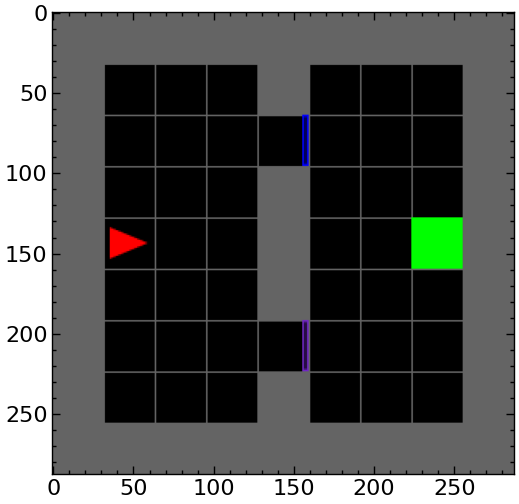

In [8]:
from gymnasium import spaces
from enum import IntEnum
from functools import partial

class DiscreteActions(IntEnum):
    move_left = 0
    move_right = 1
    move_up = 2
    move_down = 3

class DynamicsGeneralization(MiniGridEnv):
    def __init__(
        self,
        size=9,
        agent_start_pos=(1, 4),
        agent_start_dir=0,
        max_steps: int | None = None,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir

        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            max_steps=max_steps,
            **kwargs,
        )

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def _gen_grid(self, width, height, layout_type=None):
        # Create an empty grid
        self.grid = Grid(width, height)

        self.grid.wall_rect(0, 0, width, height)

        # Generate vertical separation wall
        for i in range(0, height):
            self.grid.set(4, i, Wall())
        
        # # Place the door and key
        if layout_type == 1:
            self.grid.set(4, 2, Door(COLOR_NAMES[0], is_locked=False, is_open=True))
        # self.grid.set(4, 4, Door(COLOR_NAMES[1], is_locked=False, is_open=True))
        elif layout_type == 0:
            self.grid.set(4, 6, Door(COLOR_NAMES[3], is_locked=False, is_open=True))
        else:
            self.grid.set(4, 2, Door(COLOR_NAMES[0], is_locked=False, is_open=True))
            self.grid.set(4, 6, Door(COLOR_NAMES[3], is_locked=False, is_open=True))
            
        # # Place a goal square in the bottom-right corner
        self.put_obj(Goal(), width - 2, 4)
        self.goal_pos = np.array((width-2, 4))
        
        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"

class MinigridWrapper:
    def __init__(self, env):
        self.env = SymbolicObsWrapper(env)
        self.env.unwrapped.actions = DiscreteActions
        self.env.unwrapped.action_space = spaces.Discrete(len(self.env.unwrapped.actions))
        
    def step(self, action):
        self.coverage_map[self.env.unwrapped.agent_pos[1], self.env.unwrapped.agent_pos[0]] += 1
        self.env.unwrapped.step_count += 1

        reward = 0
        terminated = False
        truncated = False

        # Get the current position of the agent
        current_pos = np.array(self.env.unwrapped.agent_pos)

        # Calculate the new position based on the action
        if action == self.env.unwrapped.actions.move_left:
            new_pos = current_pos + np.array([-1, 0])
        elif action == self.env.unwrapped.actions.move_right:
            new_pos = current_pos + np.array([1, 0])
        elif action == self.env.unwrapped.actions.move_up:
            new_pos = current_pos + np.array([0, -1])
        elif action == self.env.unwrapped.actions.move_down:
            new_pos = current_pos + np.array([0, 1])
        else:
            raise ValueError(f"Invalid action: {action}")

        # Clip the new position to ensure it stays within the grid boundaries
        new_pos = np.clip(new_pos, [0, 0], [self.env.unwrapped.width - 1, self.env.unwrapped.height - 1])

        # Get the contents of the cell at the new position
        new_cell = self.env.unwrapped.grid.get(*new_pos)

        # Move the agent if the new cell is walkable
        if new_cell is None or new_cell.can_overlap():
            self.env.unwrapped.agent_pos = tuple(new_pos)

        # Check if the new cell is a goal or lava
        if new_cell is not None and new_cell.type == "goal":
            terminated = True
            reward = self.env.unwrapped._reward()
        if new_cell is not None and new_cell.type == "lava":
            terminated = True

        # Check if the episode is truncated due to step limit
        if self.env.unwrapped.step_count >= self.env.unwrapped.max_steps:
            truncated = True

        # Generate the observation and return the result
        obs = self.env.unwrapped.gen_obs()
        return self.env.observation(obs), reward, terminated, truncated, {"goal_pos": self.env.unwrapped.goal_pos}
    
    # def step(self, action):
    #     self.coverage_map[self.env.unwrapped.agent_pos[1], self.env.unwrapped.agent_pos[0]] += 1
    #     self.env.unwrapped.step_count += 1

    #     reward = 0
    #     terminated = False
    #     truncated = False

    #     # Rotate left
    #     if action == self.env.unwrapped.actions.move_left:
    #         self.env.unwrapped.agent_dir -= 1
    #         if self.env.unwrapped.agent_dir < 0:
    #             self.env.unwrapped.agent_dir += 4

    #     # Rotate right
    #     elif action == self.env.env.actions.move_right:
    #         self.env.env.agent_dir = (self.env.env.agent_dir + 1) % 4
            
    #     elif action == self.env.env.actions.move_forward:
    #         pass
        
    #     # Get the position in front of the agent
    #     fwd_pos = self.env.unwrapped.front_pos

    #     # Get the contents of the cell in front of the agent
        
    #     fwd_cell = self.env.unwrapped.grid.get(*fwd_pos)
        
    #     if fwd_cell is None or fwd_cell.can_overlap():
    #         self.env.unwrapped.agent_pos = tuple(fwd_pos)
    #     if fwd_cell is not None and fwd_cell.type == "goal":
    #         terminated = True
    #         reward = self.env.unwrapped._reward()
    #     if fwd_cell is not None and fwd_cell.type == "lava":
    #         terminated = True

    #     if self.env.unwrapped.step_count >= self.env.unwrapped.max_steps:
    #         truncated = True

    #     obs = self.env.unwrapped.gen_obs()
    #     return self.env.observation(obs), reward, terminated, truncated, {"goal_pos": self.env.unwrapped.goal_pos}
    
    def reset(self):
        self.coverage_map = np.zeros(shape=(self.env.unwrapped.width, self.env.unwrapped.height))
        obs, info = self.env.reset()
        info['goal_pos'] = self.env.unwrapped.goal_pos
        return obs, info
    
    def render(self):
        return self.env.render()
    
    def visualize_coverage(self):
        plt.imshow(self.coverage_map, cmap='inferno', vmin=0)
        plt.colorbar()
        plt.show()

    def get_grid_array(self):
        grid = (env.env.unwrapped.grid.encode()[:, :, 0].T).astype(np.int16)
        print(grid)
        grid = np.where(grid == 2, -1000, grid)
        return grid
    
    def plot_grid(self, ax, grid, add_start=False):
        asbestos = (0.2, 0.2, 0.2, 1.0)
        grid_kwargs = {'color': (220 / 255, 220 / 255, 220 / 255, 0.5)}
        img = np.ones((self.env.unwrapped.width, self.env.unwrapped.height, 4))
        wall_y, wall_x = np.where(grid == -1000)
        for i in range(len(wall_y)):
            img[wall_y[i], wall_x[i]] = np.array(asbestos)
        ax.imshow(img, interpolation=None)
        ax.grid(0)
        plt.xticks([])
        plt.yticks([])
        if add_start:
            plt.text(
            self.start[1],
            self.start[0],
            r'$\mathbf{S}$',
            fontsize=16,
            ha='center',
            va='center')
        h, w = (self.env.unwrapped.width, self.env.unwrapped.height)
        for y in range(h - 1):
            plt.plot([-0.5, w - 0.5], [y + 0.5, y + 0.5], **grid_kwargs)
        for x in range(w - 1):
            plt.plot([x + 0.5, x + 0.5], [-0.5, h - 0.5], **grid_kwargs)
        return ax
        
env = DynamicsGeneralization(render_mode="rgb_array", highlight=False, max_steps=200)
# env._gen_grid = partial(env._gen_grid, layout_type=1)
env = MinigridWrapper(env)

env.reset()
plt.imshow(env.render())

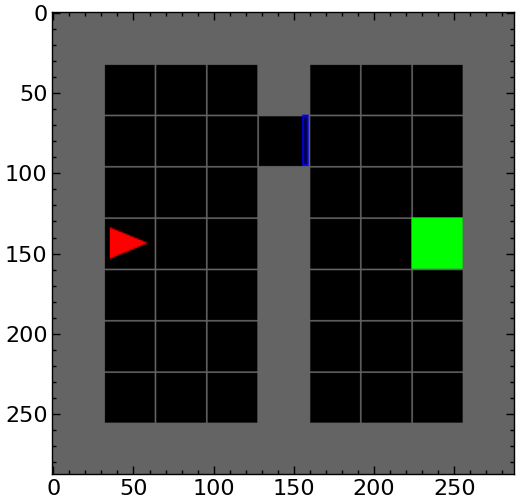

In [3]:
env.step(0)
plt.imshow(env.render())

In [4]:
def random_exploration(env, num_episodes=1, layout_type: int=0): # 2000
    dataset = dict()
    observations = []
    actions = []
    dones = []

    available_actions = np.array([0, 1, 2, 3])
    for _ in range(num_episodes):
        i=0
        env.reset()
        cur_observations = []
        cur_actions = []
        cur_dones = []
        done = False
        while not done:
            i+=1
            # print(env.env.unwrapped.agent_pos)
            cur_observations.append(np.array(env.env.unwrapped.agent_pos, dtype=np.float32))
            action = np.random.choice(available_actions, replace=True)
            # print(action)
            next_state, reward, terminated, truncated, info = env.step(action)
            cur_actions.append(np.array(action, dtype=np.float32))
            done = truncated
            cur_dones.append(np.array(done, dtype=np.float32))

        observations.append(np.stack(cur_observations))
        actions.append(np.stack(cur_actions))
        dones.append(np.stack(cur_dones))
    
    dataset['observations'] = np.concatenate(observations)
    dataset['terminals'] = np.concatenate(dones)
    dataset['actions'] = np.concatenate(actions)
    
    ob_mask = (1.0 - dataset['terminals']).astype(bool)
    # print(len(np.nonzero(ob_mask)[0]))
    next_ob_mask = np.concatenate([[False], ob_mask[:-1]])
    dataset['next_observations'] = dataset['observations'][next_ob_mask]
    dataset['observations'] = dataset['observations'][ob_mask]
    dataset['actions'] = dataset['actions'][ob_mask].astype(jnp.int8)
    new_terminals = np.concatenate([dataset['terminals'][1:], [1.0]])
    dataset['terminals'] = new_terminals[ob_mask].astype(np.float32)
    dataset['layout_type'] = np.repeat(np.array(layout_type), repeats=(dataset['actions'].shape[0], ))
    return dataset, env

# NUM_LAYOUTS = fb_config['agent']['number_of_meta_envs']
train_layout_data = []
for i in tqdm(range(1)):
    env = DynamicsGeneralization(render_mode="rgb_array", highlight=False, max_steps=200)
    env._gen_grid = partial(env._gen_grid, layout_type=i)
    env = MinigridWrapper(env)
    dataset_random, env = random_exploration(env, layout_type=i)
    train_layout_data.append(dataset_random)

# ds, env = random_exploration(env)
# env.visualize_coverage()

  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
import functools
from utils.datasets import Dataset, GCDataset

with initialize(version_base=None, config_path="../configs/"):
    iql_config = compose(config_name='entry.yaml', overrides=['experiment=iql.yaml'])
    iql_config = OmegaConf.to_container(iql_config, resolve=True)
    pprint(iql_config)
    
def concatenate_dicts(dict1, dict2):
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), dict1, dict2)

whole_data = functools.reduce(concatenate_dicts, train_layout_data)
print(jax.tree.map(lambda x: x.shape, whole_data))
whole_dataset = Dataset.create(**jax.device_get(whole_data))
gc_whole_dataset = GCDataset(whole_dataset, config=iql_config['agent'])

# batch, batch_context, batch_context2 = gc_whole_dataset.sample(1, layout_type=1, context_length=20)

{
│   'seed': 1337,
│   'run_group': 'dynamics_aware_iql',
│   'save_dir': 'experiment_logs/',
│   'train_steps': 1000000,
│   'log_interval': 5000,
│   'eval_interval': 10000,
│   'eval_tasks': None,
│   'eval_episodes': 1,
│   'eval_temperature': 0,
│   'eval_gaussian': None,
│   'video_episodes': 1,
│   'video_frame_skip': 3,
│   'eval_on_cpu': 0,
│   'frame_stack': None,
│   'p_aug': None,
│   'agent': {
│   │   'agent_name': 'dynamics_aware_iql',
│   │   'lr': 0.0003,
│   │   'batch_size': 1024,
│   │   'discrete': True,
│   │   'discount': 0.99,
│   │   'tau': 0.01,
│   │   'clip_by_global_norm': True,
│   │   'dataset_class': 'GCDataset',
│   │   'value_p_curgoal': 0.2,
│   │   'value_p_trajgoal': 0.5,
│   │   'value_p_randomgoal': 0.3,
│   │   'value_geom_sample': True,
│   │   'actor_p_curgoal': 0.0,
│   │   'actor_p_trajgoal': 1.0,
│   │   'actor_p_randomgoal': 0.0,
│   │   'actor_geom_sample': False,
│   │   'gc_negative': True,
│   │   'p_aug': 0.0,
│   │   'frame_stack': None,
│   │   'const_std': True,
│   │   'actor_hidden_dims': [512, 512, 512],
│   │   'value_hidden_dims': [512, 512, 512],
│   │   'layer_norm': True,
│   │   'actor_loss': 'awr',
│   │   'alpha': 0.003,
│   │   'use_context': True,
│   │   'warmup_steps': 50000,
│   │   'n_blocks': 2,
│   │   'n_heads': 5,
│   │   'h_dim': 150,
│   │   'context_len': 512,
│   │   'number_of_meta_envs': 20,
│   │   'use_masked_attention': False,
│   │   'use_mean_embedding': True,
│   │   'cosine_schedule': False,
│   │   'expectile': 0.9
│   },
│   'env': {'env_name': 'maze-fourrooms-11', 'discrete': True, 'action_dim': 4},
│   'tags': ['dynamical_iql', 'discrete']
}

{'actions': (199,), 'layout_type': (199,), 'next_observations': (199, 2), 'observations': (199, 2), 'terminals': (199,)}


In [6]:
example_batch = gc_whole_dataset.sample(1)
pprint(jax.tree.map(lambda x: x.shape, example_batch))
iql_agent = GCIQLAgent.create(
    0,
    example_batch['observations'],
    np.full_like(example_batch['actions'], env.env.action_space.n - 1),
    config=iql_config['agent']
)
batch, batch_context, batch_context2 = gc_whole_dataset.sample(1, layout_type=0, context_length=20)

{
│   'actions': (1,),
│   'actor_goals': (1, 2),
│   'layout_type': (1,),
│   'masks': (1,),
│   'next_observations': (1, 2),
│   'observations': (1, 2),
│   'rewards': (1,),
│   'terminals': (1,),
│   'value_goals': (1, 2)
}

In [7]:
iql_agent.update(batch, batch_context)

(GCIQLAgent(rng=Array([4165894930,  804218099], dtype=uint32), network=TrainState(step=Array(2, dtype=int32, weak_type=True), apply_fn=<bound method Module.apply of ModuleDict(
     # attributes
     modules = {'value': GCValue(
         # attributes
         hidden_dims = [512, 512, 512]
         layer_norm = True
         ensemble = False
         gc_encoder = None
     ), 'critic': GCDiscreteCritic(
         # attributes
         hidden_dims = [512, 512, 512]
         layer_norm = True
         ensemble = True
         gc_encoder = None
         action_dim = np.int8(4)
     ), 'target_critic': GCDiscreteCritic(
         # attributes
         hidden_dims = [512, 512, 512]
         layer_norm = True
         ensemble = True
         gc_encoder = None
         action_dim = np.int8(4)
     ), 'actor': GCDiscreteActor(
         # attributes
         hidden_dims = [512, 512, 512]
         action_dim = np.int8(4)
         final_fc_init_scale = 0.01
         gc_encoder = None
         layer

In [ ]:
pbar = tqdm(range(100_000))
for update_steps in pbar:
    # batch = gc_whole_dataset.sample(iql_config['agent']['batch_size'])
    batch, batch_context, _ = gc_whole_dataset.sample(32, layout_type=update_steps % 2, context_length=iql_config['agent']['batch_size'])
    iql_agent, info = iql_agent.update(batch, batch_context)
    if update_steps % 1_000 == 0:
        pbar.set_postfix({"critic_loss": info['critic/critic_loss'],
                          "value_loss": info['value/value_loss'],
                          "actor_loss": info['actor/actor_loss']})

[[2 2 2 2 2 2 2 2 2]
 [2 1 1 1 2 1 1 1 2]
 [2 1 1 1 4 1 1 1 2]
 [2 1 1 1 2 1 1 1 2]
 [2 1 1 1 2 1 1 8 2]
 [2 1 1 1 2 1 1 1 2]
 [2 1 1 1 4 1 1 1 2]
 [2 1 1 1 2 1 1 1 2]
 [2 2 2 2 2 2 2 2 2]]


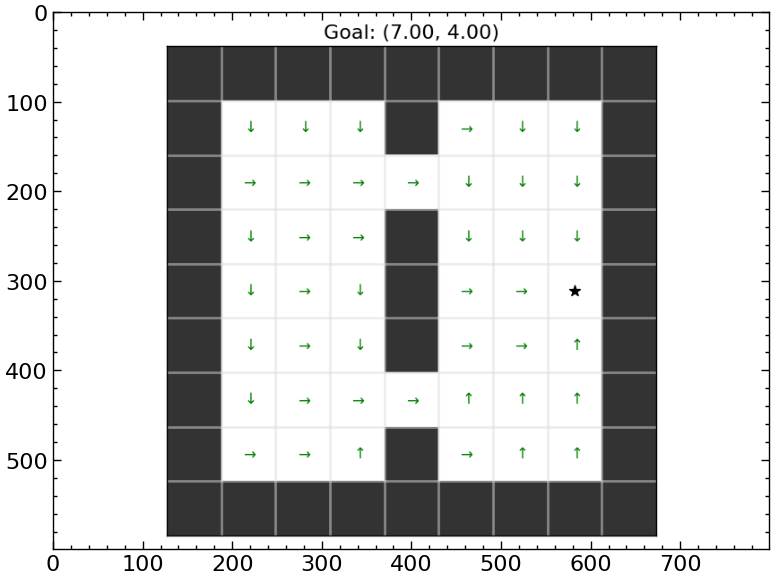

In [37]:
from functools import partial
from utils.evaluation import supply_rng
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def get_canvas_image(canvas):
    canvas.draw() 
    out_image = np.asarray(canvas.buffer_rgba())
    return out_image

def policy_image_grid(env, dataset, action_fn=None, **kwargs):
    fig = plt.figure(tight_layout=True)
    canvas = FigureCanvas(fig)
    plot_policy(env, dataset, fig=fig, ax=plt.gca(), action_fn=action_fn, **kwargs)
    image = get_canvas_image(canvas)
    plt.close(fig)
    return image

def plot_policy(env, dataset, fig=None, ax=None, title=None, action_fn=None, **kwargs):
    action_names = [
            r'$\leftarrow$', r'$\rightarrow$', r'$\uparrow$', r'$\downarrow$'
        ]
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    
    grid = env.get_grid_array()
    ax = env.plot_grid(ax=ax, grid=grid)
    
    goal = kwargs.get('goal', None)
    for (y, x), value in np.ndenumerate(grid):
        if value == 1 or value == 4:# and np.array([y, x]) != env.goal:
            action = action_fn(np.concatenate([[x], [y]], -1)).squeeze()
            # print(y, x)
            # print(action)
            action_name = action_names[action]# + r'$\curvearrowleft$'
            ax.text(x, y, action_name, ha='center', va='center', fontsize='large', color='green')
            
        # if np.array_equal(np.array([y, x]),goal):
    ax.set_title('Goal: ({:.2f}, {:.2f})'.format(goal[0], goal[1])) 
    ax.scatter(goal[0], goal[1], s=80, c='black', marker='*')
        
    if title:
        ax.set_title(title)
        
    return fig, ax

env = DynamicsGeneralization(render_mode="rgb_array", highlight=False, max_steps=200)
# env._gen_grid = partial(env._gen_grid, layout_type=0)
env = MinigridWrapper(env)
obs, info = env.reset()
goal = info.get("goal_pos", None)
example_batch = whole_dataset.sample(1)
pred_policy_img = policy_image_grid(env, example_batch,
                                                action_fn=partial(supply_rng(iql_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))),
                                                                  goals=goal, temperature=0.0),
                                                goal=goal)
plt.imshow(pred_policy_img)
plt.tight_layout()

[[2 2 2 2 2 2 2 2 2]
 [2 1 1 1 2 1 1 1 2]
 [2 1 1 1 4 1 1 1 2]
 [2 1 1 1 2 1 1 1 2]
 [2 1 1 1 2 1 1 8 2]
 [2 1 1 1 2 1 1 1 2]
 [2 1 1 1 4 1 1 1 2]
 [2 1 1 1 2 1 1 1 2]
 [2 2 2 2 2 2 2 2 2]]


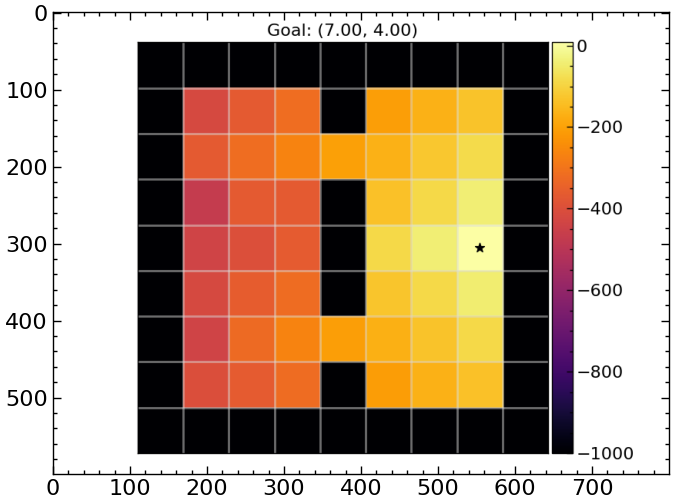

In [38]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def value_image_fourrooms(env, dataset, value_fn, action_fn=None, **kwargs):
    fig = plt.figure(tight_layout=True)
    canvas = FigureCanvas(fig)
    plot_value_image_grid(env, dataset, value_fn, fig=fig, ax=plt.gca(), action_fn=action_fn, **kwargs)
    image = get_canvas_image(canvas)
    plt.close(fig)
    return image

def value_fn(agent, obs, goal, action):
    q1, q2 = agent.network.select('critic')(obs, goal, action)
    q = jnp.minimum(q1, q2)
    return q / 0.03

def plot_value_image_grid(env, dataset, value_fn, action_fn, fig=None, ax=None, title=None, **kwargs):
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    
    goal = kwargs.get('goal', None)
    grid = env.get_grid_array()
    ax = env.plot_grid(ax=ax, grid=grid)
    # print(grid)
    for (y, x), value in np.ndenumerate(grid):
        if value == 1 or value == 4:
            action = action_fn(np.concatenate([[x], [y]], -1)).squeeze()
            grid[y, x] = jax.device_get(value_fn(np.concatenate([[x], [y]], -1), goal, action))
            
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.imshow(grid, cmap='inferno', vmin=-1000)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if goal is not None:
        ax.set_title('Goal: ({:.2f}, {:.2f})'.format(goal[0], goal[1])) 
        ax.scatter(goal[0], goal[1], s=80, c='black', marker='*')
    return fig, ax

env = DynamicsGeneralization(render_mode="rgb_array", highlight=False, max_steps=200)
# env._gen_grid = partial(env._gen_grid, layout_type=1)
env = MinigridWrapper(env)
env.reset()

pred_value_img = value_image_fourrooms(env, example_batch,
                            value_fn=partial(value_fn, iql_agent), action_fn=partial(supply_rng(iql_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))),
                                                                  goals=goal, temperature=0.0), goal=goal)
plt.imshow(pred_value_img)
